In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from scipy import stats
import pyhere


In [2]:
dir_data_raw = pyhere.here().resolve().joinpath("data", "raw")
dir_data_interim = pyhere.here().resolve().joinpath("data", "interim")
dir_data_external = pyhere.here().resolve().joinpath("data", "external")

In [3]:
csv_power_plants = pd.read_csv(dir_data_interim/"power_plants_with_generation_transformed.csv", index_col=[0])

In [4]:
df_transformed = pd.read_csv(dir_data_external/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed

,latitude,longitude,ANN_ALLSKY_KT_2012,ANN_ALLSKY_KT_2013,ANN_ALLSKY_KT_2014,ANN_ALLSKY_KT_2015,ANN_ALLSKY_KT_2016,ANN_ALLSKY_KT_2017,ANN_ALLSKY_KT_2018,ANN_ALLSKY_KT_2019,...,winter_WS50M_MAX_AVG_2018,winter_WS50M_MAX_AVG_2019,winter_WS50M_MIN_AVG_2012,winter_WS50M_MIN_AVG_2013,winter_WS50M_MIN_AVG_2014,winter_WS50M_MIN_AVG_2015,winter_WS50M_MIN_AVG_2016,winter_WS50M_MIN_AVG_2017,winter_WS50M_MIN_AVG_2018,winter_WS50M_MIN_AVG_2019
index,,,,,,,,,,,,,,,,,,,,,
0,32.3220,65.1190,0.69,0.70,0.70,0.68,0.71,0.71,0.70,0.69,...,6.966667,6.850000,1.283333,1.003333,1.023333,1.006667,0.950000,1.320000,1.176667,1.176667
1,31.6700,65.7950,0.70,0.70,0.70,0.69,0.72,0.71,0.70,0.69,...,7.606667,7.903333,1.663333,1.473333,1.290000,1.520000,1.543333,1.613333,1.476667,1.603333
2,31.6230,65.7920,0.70,0.70,0.70,0.69,0.72,0.71,0.70,0.69,...,7.606667,7.903333,1.663333,1.473333,1.290000,1.520000,1.543333,1.613333,1.476667,1.603333
3,34.5560,69.4787,0.65,0.65,0.65,0.63,0.66,0.67,0.67,0.65,...,5.126667,5.426667,1.870000,1.380000,1.606667,1.260000,1.473333,1.873333,1.210000,1.516667
4,34.6410,69.7170,0.65,0.65,0.65,0.63,0.66,0.67,0.67,0.65,...,4.650000,4.740000,1.616667,1.020000,1.063333,0.743333,0.936667,1.336667,0.916667,0.923333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34931,-12.9667,28.6333,0.59,0.60,0.59,0.59,0.60,0.57,0.59,0.59,...,6.050000,5.556667,2.056667,2.323333,2.373333,2.510000,1.760000,2.160000,2.183333,1.750000
34932,-12.8167,28.2000,0.59,0.60,0.59,0.59,0.60,0.57,0.59,0.59,...,6.076667,5.696667,2.090000,2.503333,2.360000,2.596667,1.806667,2.246667,2.200000,1.790000
34933,-17.9167,25.8500,0.62,0.62,0.61,0.64,0.62,0.59,0.62,0.65,...,6.873333,7.233333,2.180000,2.910000,2.400000,3.120000,2.076667,2.496667,2.300000,2.903333


In [5]:
df_transformed.columns

Index(['latitude', 'longitude', 'ANN_ALLSKY_KT_2012', 'ANN_ALLSKY_KT_2013',
       'ANN_ALLSKY_KT_2014', 'ANN_ALLSKY_KT_2015', 'ANN_ALLSKY_KT_2016',
       'ANN_ALLSKY_KT_2017', 'ANN_ALLSKY_KT_2018', 'ANN_ALLSKY_KT_2019',
       ...
       'winter_WS50M_MAX_AVG_2018', 'winter_WS50M_MAX_AVG_2019',
       'winter_WS50M_MIN_AVG_2012', 'winter_WS50M_MIN_AVG_2013',
       'winter_WS50M_MIN_AVG_2014', 'winter_WS50M_MIN_AVG_2015',
       'winter_WS50M_MIN_AVG_2016', 'winter_WS50M_MIN_AVG_2017',
       'winter_WS50M_MIN_AVG_2018', 'winter_WS50M_MIN_AVG_2019'],
      dtype='object', length=282)

In [6]:
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
csv_power_plants


,capacity_mw,latitude,longitude,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,primary_fuel_transformed
index,,,,,,,,,,,
0,33.0,32.3220,65.1190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
1,10.0,31.6700,65.7950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solar
2,10.0,31.6230,65.7920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solar
3,66.0,34.5560,69.4787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
4,100.0,34.6410,69.7170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
...,...,...,...,...,...,...,...,...,...,...,...
34931,50.0,-12.9667,28.6333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
34932,20.0,-12.8167,28.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
34933,108.0,-17.9167,25.8500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other


In [7]:
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

In [8]:
df_transformed_combined

,latitude,longitude,ANN_ALLSKY_KT_2012,ANN_ALLSKY_KT_2013,ANN_ALLSKY_KT_2014,ANN_ALLSKY_KT_2015,ANN_ALLSKY_KT_2016,ANN_ALLSKY_KT_2017,ANN_ALLSKY_KT_2018,ANN_ALLSKY_KT_2019,...,winter_WS50M_MIN_AVG_2019,capacity_mw,primary_fuel_transformed,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019
index,,,,,,,,,,,,,,,,,,,,,
0,32.3220,65.1190,0.69,0.70,0.70,0.68,0.71,0.71,0.70,0.69,...,1.176667,33.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31.6700,65.7950,0.70,0.70,0.70,0.69,0.72,0.71,0.70,0.69,...,1.603333,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31.6230,65.7920,0.70,0.70,0.70,0.69,0.72,0.71,0.70,0.69,...,1.603333,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.5560,69.4787,0.65,0.65,0.65,0.63,0.66,0.67,0.67,0.65,...,1.516667,66.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34.6410,69.7170,0.65,0.65,0.65,0.63,0.66,0.67,0.67,0.65,...,0.923333,100.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34931,-12.9667,28.6333,0.59,0.60,0.59,0.59,0.60,0.57,0.59,0.59,...,1.750000,50.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34932,-12.8167,28.2000,0.59,0.60,0.59,0.59,0.60,0.57,0.59,0.59,...,1.790000,20.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34933,-17.9167,25.8500,0.62,0.62,0.61,0.64,0.62,0.59,0.62,0.65,...,2.903333,108.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN


primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

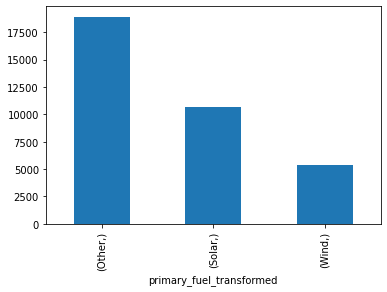

In [9]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [10]:
df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Other                       4651
Wind                         767
Solar                        612
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

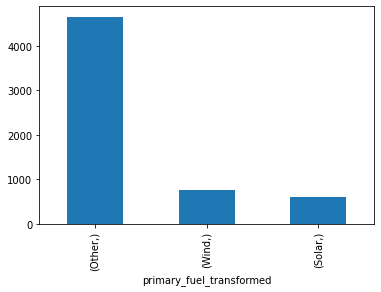

In [11]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [12]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
df_transformed_combined.dropna(inplace = True)
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


/tmp/ipykernel_1656/2191278475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed_combined.dropna(inplace = True)
/tmp/ipykernel_1656/2191278475.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [13]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
24713,Solar,1
24717,Other,0
24749,Wind,2


## Balancing the data

In [14]:
index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(4000).index
# index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(14000).index
# index_rows_to_delete = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(9000).index
index_rows_to_delete_wind = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 2].sample(100).index
# index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(5500).index
# index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(3000).index


In [15]:
df_transformed_combined.drop(index_rows_to_delete_other, axis = 0, inplace = True)
# df_transformed_combined.drop(index_rows_to_delete_solar, axis = 0, inplace = True)
df_transformed_combined.drop(index_rows_to_delete_wind, axis = 0, inplace = True)

/tmp/ipykernel_1656/2674744941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed_combined.drop(index_rows_to_delete_other, axis = 0, inplace = True)
/tmp/ipykernel_1656/2674744941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed_combined.drop(index_rows_to_delete_wind, axis = 0, inplace = True)


<AxesSubplot:xlabel='primary_fuel_transformed'>

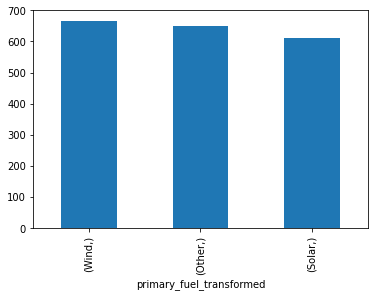

In [16]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [17]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
pre_X = df_transformed_combined.drop(columns=columns_to_drop)
# pre_X.dropna(inplace = True)
X = pre_X.drop(columns=['code_prim_fuel_transf'])
y = pre_X['code_prim_fuel_transf']

In [18]:
y

index
24713    1
24715    1
24716    1
24719    1
24730    1
        ..
34499    0
34512    1
34520    0
34540    2
34542    0
Name: code_prim_fuel_transf, Length: 1930, dtype: int64

In [19]:
# sns.kdeplot(data=pre_X, x='winter_TQV_2009', hue='code_prim_fuel_transf', shade=True)

In [20]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [21]:
def get_accuracy(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [22]:
def get_accuracy_knn(n_neighbors, X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier(n_neighbors = n_neighbors)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [23]:
mi_scores = make_mi_scores(X, y)
mi_scores[::3]

winter_WS10M_MAX_AVG_2012        0.439391
spring_WS10M_MAX_AVG_2016        0.432755
autumn_WS50M_MAX_AVG_2014        0.428881
winter_WS50M_MAX_AVG_2016        0.425339
autumn_ALLSKY_SFC_SW_DWN_2014    0.421995
                                   ...   
autumn_ALLSKY_KT_2012            0.218834
winter_ALLSKY_KT_2014            0.200169
ANN_ALLSKY_KT_2012               0.179961
ANN_ALLSKY_KT_2017               0.147026
ANN_ALLSKY_KT_2019               0.129318
Name: MI Scores, Length: 94, dtype: float64

In [24]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

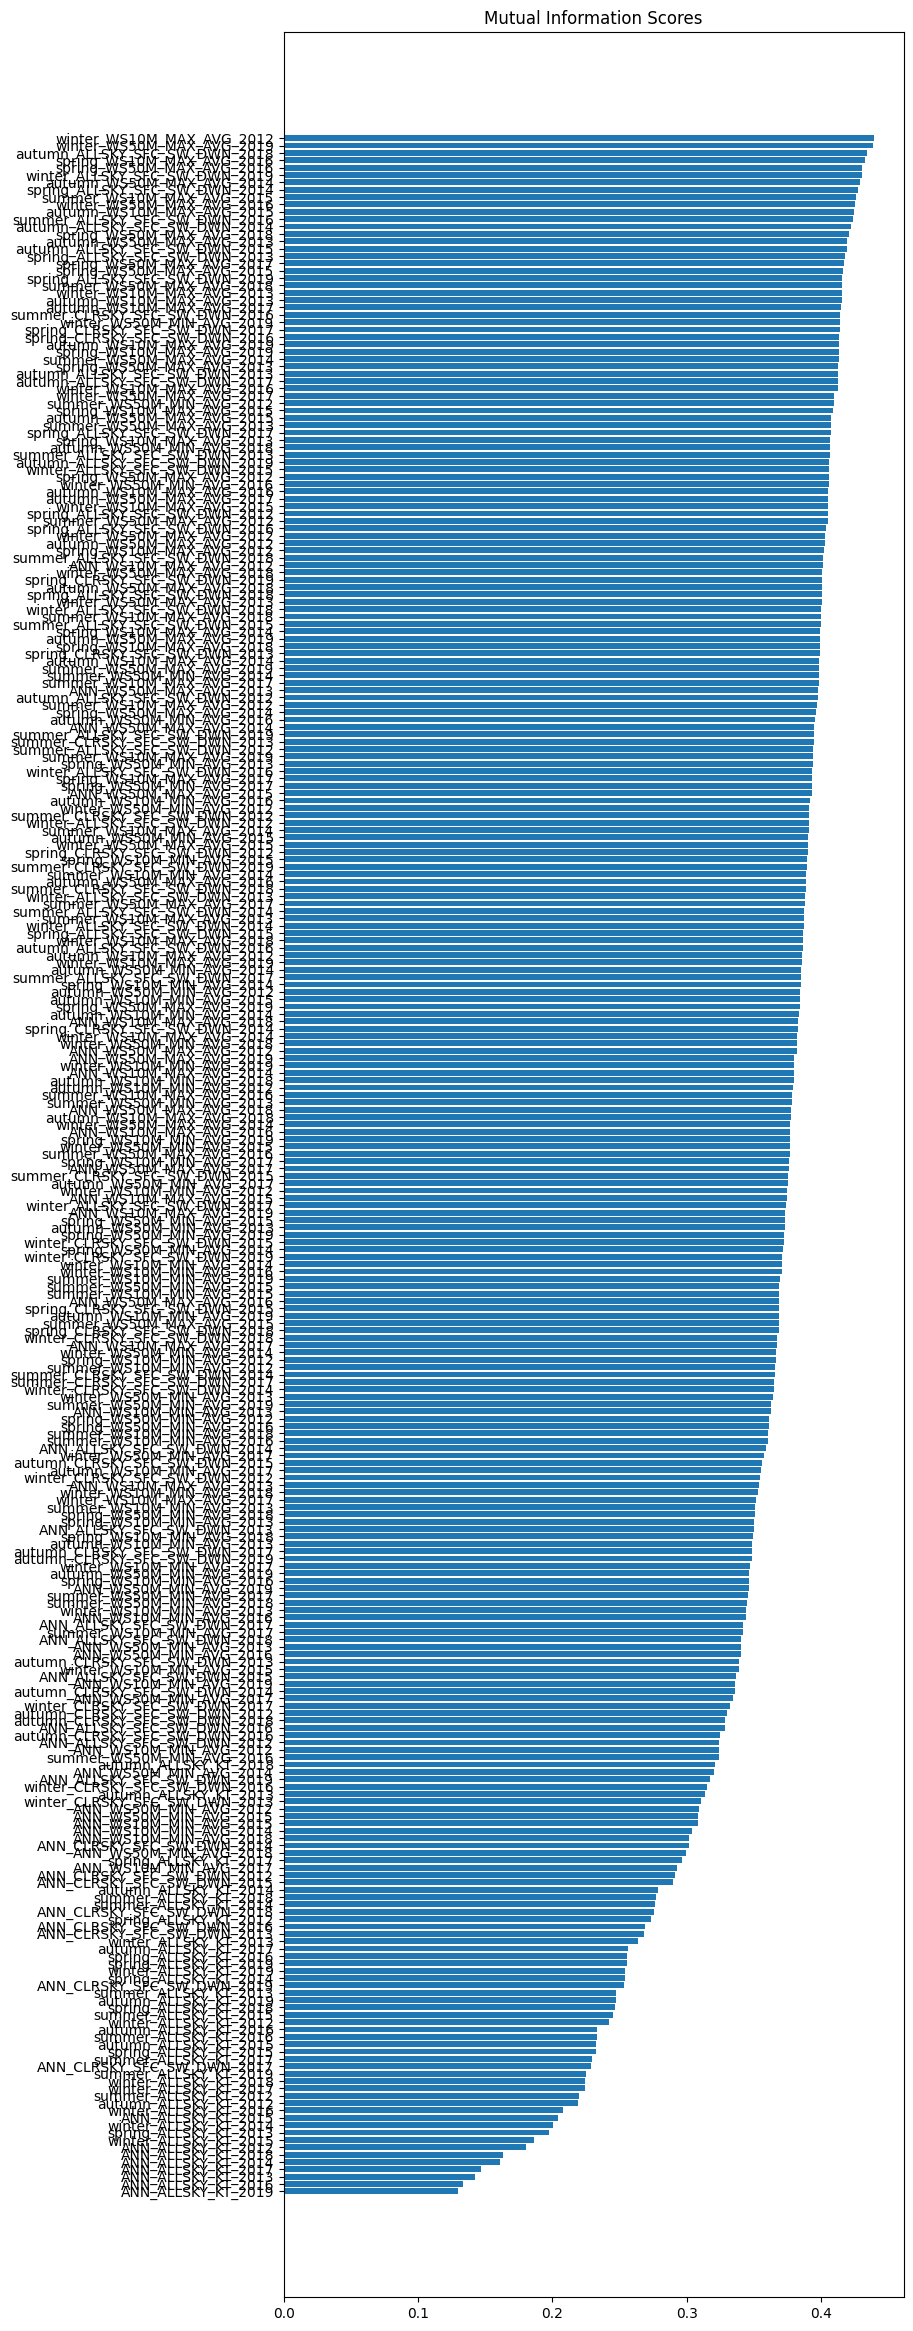

In [25]:
plt.figure(dpi=100, figsize=(8, 30))
plot_mi_scores(mi_scores)

In [222]:
 columns_delete = X.columns.str.contains('ALLSKY_KT')
 X = X.loc[:,~columns_delete]

In [26]:
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

## DECISION TREE CLASSIFIER

50


<AxesSubplot:>

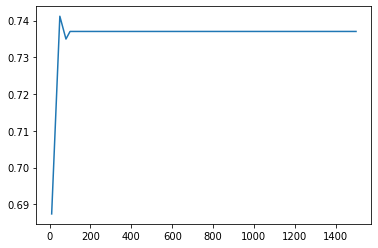

In [27]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {node: get_accuracy(node, train_X, val_X, train_y, val_y) for node in candidate_max_leaf_nodes}
# results = {node: get_accuracy(node, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for node in candidate_max_leaf_nodes}
# for node in candidate_max_leaf_nodes:
#     results[node] = get_accuracy(node, X_train, X_test, y_train, y_test)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [225]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(train_X, train_y)
y_pred = tree_model.predict(val_X)
# print(cross_val_score(tree_model, X, y, cv=5))

<AxesSubplot:>

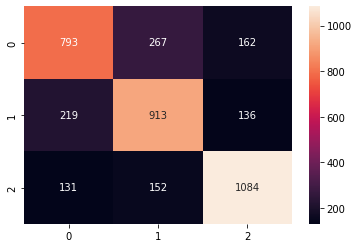

In [226]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [31]:
accuracy_score(val_y, y_pred)

0.782608695652174

In [32]:
precision_score(val_y, y_pred, average='weighted')

0.7861190641214041

In [33]:
tree_model.score(val_X, val_y)

0.782608695652174

In [34]:
# tree.plot_tree(tree_model)

# RANDOM FOREST CLASSIFIER

In [28]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [50, 100, 500]
# Minimum numbers of samples required to split a node
min_samples_split = [2, 10, 50, ]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [10, 100, 500]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [29]:
rf_model = RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
# rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 50, cv=5, verbose = 2, n_jobs=4)

In [30]:
# rf_grid.fit(train_X_scaled_pca, train_y)
rf_grid.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [50, 100, 500],
                         'max_leaf_nodes': [10, 100, 500],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'min_samples_split': [2, 10, 50],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [31]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 40}

In [32]:
rf_grid.score(val_X, val_y)
# rf_grid.score(val_X_scaled_pca, val_y)

0.7619047619047619

In [33]:
rf_model2 = RandomForestClassifier(bootstrap= True,
 max_depth= 50,
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 40,
 max_leaf_nodes= 100,
 random_state=0)
rf_model2.fit(train_X, train_y)
y_pred = rf_model2.predict(val_X)
# print(cross_val_score(tree_model, X, y, cv=5))

<AxesSubplot:>

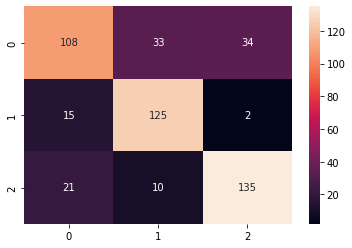

In [34]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [35]:
accuracy_score(val_y, y_pred)

0.7619047619047619

In [43]:
rf_model2.score(val_X, val_y)

0.7039337474120083

0    167
2    166
1    150
Name: code_prim_fuel_transf, dtype: int64


<AxesSubplot:>

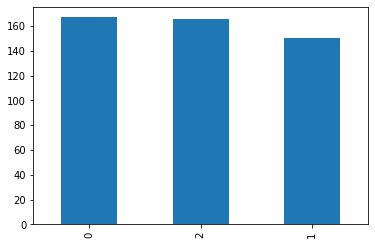

In [44]:
print(val_y.value_counts())
val_y.value_counts().plot.bar()

# XGBOOST

In [27]:
xgbclass_model_1 = XGBClassifier(random_state=0)
xgbclass_model_1.fit(train_X, train_y)
# xgbclass_model_1.fit(train_X_scaled_pca, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [28]:
# y_pred = xgbclass_model_1.predict(val_X_scaled_pca)
y_pred = xgbclass_model_1.predict(val_X)

In [29]:
# xgbclass_model_1.score(val_X_scaled_pca, val_y)
xgbclass_model_1.score(val_X, val_y)

0.7660455486542443

<AxesSubplot:>

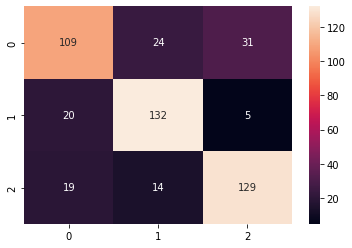

In [30]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [31]:
param_grid = {
                'n_estimators': [5,10,50,100,500,1000],
                'learning_rate': [0.01,0.05,0.1,0.2],
                'max_depth': [2,3,4],
            }

In [34]:
xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)

In [35]:
xgb_grid.fit(train_X, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ....learning_rate=0.01, max_depth=2, n_estimators=5; total time=   0.4s
[CV] END ....learning_rate=0.01, max_depth=2, n_estimators=5; total time=   0.4s
[CV] END ....learning_rate=0.01, max_depth=2, n_estimators=5; total time=   0.4s
[CV] END ....learning_rate=0.01, max_depth=2, n_estimators=5; total time=   0.4s
[CV] END ....learning_rate=0.01, max_depth=2, n_estimators=5; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=10; total time=   0.7s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=10; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=10; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=10; total time=   0.7s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=10; total time=   0.7s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   3.3s
[CV] END ...learning_rate=0.01, max_depth=2, n_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [5, 10, 50, 100, 500, 1000]},
             verbose=2)

In [36]:
xgb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}

In [37]:
xgb_grid.score(val_X, val_y)

0.7432712215320911

In [38]:
xgbclass_model_2 = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4, early_stopping_rounds=5)
xgbclass_model_2.fit(train_X, train_y, 
             eval_set=[(val_X, val_y)], 
             verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [39]:
y_pred = xgbclass_model_2.predict(val_X)

In [40]:
xgbclass_model_2.score(val_X, val_y)

0.7763975155279503

<AxesSubplot:>

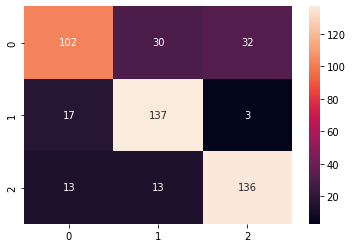

In [41]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# KNN

3


<AxesSubplot:>

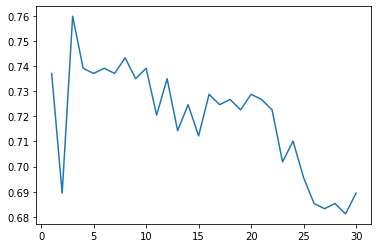

In [53]:
candidate_n_neighbors = np.arange(1,31)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


# results = {n: get_accuracy_knn(n, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for n in candidate_n_neighbors}
results = {n: get_accuracy_knn(n, train_X, val_X, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [54]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=3)

In [55]:
knn_model_1.score(val_X, val_y)

0.7598343685300207

In [52]:
# train_X_normalized = stats.boxcox(train_X)
x = train_X.values #returns a numpy array
# min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = power_transformer.fit_transform(x)
train_X_scaled = pd.DataFrame(x_scaled, index=train_X.index, columns=train_X.columns)

x = val_X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = power_transformer.fit_transform(x)
val_X_scaled = pd.DataFrame(x_scaled, index=val_X.index, columns=val_X.columns)


In [53]:
train_X_scaled

,ANN_ALLSKY_KT_2012,ANN_ALLSKY_KT_2013,ANN_ALLSKY_KT_2014,ANN_ALLSKY_KT_2015,ANN_ALLSKY_KT_2016,ANN_ALLSKY_KT_2017,ANN_ALLSKY_KT_2018,ANN_ALLSKY_KT_2019,ANN_ALLSKY_SFC_SW_DWN_2012,ANN_ALLSKY_SFC_SW_DWN_2013,...,winter_WS50M_MAX_AVG_2018,winter_WS50M_MAX_AVG_2019,winter_WS50M_MIN_AVG_2012,winter_WS50M_MIN_AVG_2013,winter_WS50M_MIN_AVG_2014,winter_WS50M_MIN_AVG_2015,winter_WS50M_MIN_AVG_2016,winter_WS50M_MIN_AVG_2017,winter_WS50M_MIN_AVG_2018,winter_WS50M_MIN_AVG_2019
index,,,,,,,,,,,,,,,,,,,,,
25715,0.506089,0.217324,0.504652,0.050902,0.473470,0.348006,0.255310,0.137477,0.510724,0.262569,...,0.485072,0.714324,1.306651,0.848856,1.367340,1.227860,1.345739,1.064123,0.930930,1.146643
26091,-0.403228,-0.960637,-0.818475,-0.723082,-0.899426,-0.589884,-0.473970,-0.967062,-0.373010,-0.763472,...,0.513176,0.460670,0.478916,0.427872,0.539445,0.431603,0.192275,0.469211,0.969789,0.548823
31525,-0.081668,-0.575601,-0.619651,-0.127060,-0.329994,-0.417909,-0.473970,-0.759080,-0.331096,-0.599670,...,0.927989,0.990970,1.072482,1.195671,0.894166,1.091497,1.077526,0.926826,0.899047,0.828650
27250,-0.924200,-1.170304,-1.028731,-1.179024,-0.899426,-0.955042,-0.990213,-1.185937,-0.841924,-1.042919,...,0.545968,0.792220,0.740637,0.778155,0.758866,0.685409,0.743324,0.557565,0.777864,0.665169
31034,0.071940,0.478165,0.368863,0.530840,0.325768,0.206432,0.507898,0.438489,-0.527692,-0.231749,...,0.197142,0.149580,-0.054561,0.525206,0.391249,0.236840,0.426996,0.149607,0.205770,0.321442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29093,1.602091,1.436603,1.535286,1.395895,1.566937,1.600897,1.427628,1.487487,1.721549,1.522432,...,-0.695330,-0.103683,-1.329086,-1.568979,-1.862652,-1.639488,-1.578970,-1.533030,-1.696697,-1.400765
30959,-0.081668,0.217324,-0.085093,0.219514,-0.155675,-0.252580,-0.018567,-0.373397,-0.527692,-0.300505,...,-0.207382,-0.342446,-0.905806,-0.614647,-0.749939,-0.392606,-0.499031,-0.998203,-0.674522,-0.605929
33084,0.220995,-0.398840,-0.619651,-0.314954,-0.329994,-0.252580,-0.473970,-0.561382,-0.137002,-0.455066,...,0.831858,0.664521,0.898490,1.002133,0.460243,0.909186,0.844588,0.607059,1.050659,1.014484


In [54]:
def axis_calculation(total_columns_df, grid_columns):
    rows = int(total_columns_df / grid_columns)
    if( total_columns_df % grid_columns) > 0:
        rows += 1

    return (rows, grid_columns)
print(axis_calculation(30, 4))

(8, 4)


In [55]:

# # plt.figure(figsize=(200,200))
# grid_columns = 5
# result_axis = axis_calculation(len(train_X_scaled.columns), grid_columns)
# fig, axs = plt.subplots(result_axis[0],result_axis[1], figsize=(30,20))
# fig.subplots_adjust(hspace=.5)

# aux_cont = 0
# aux_cont_2 = 0
# # fig.figsize=(30,30)
# for col in train_X_scaled.columns:
# # #     # print(col)
#     sns.kdeplot(data=train_X_scaled, x=col, shade=True, ax=axs[aux_cont_2, aux_cont] )
#     # axs[aux_cont_2, aux_cont].set_xlabel('Participation Rate')
#     # axs[aux_cont_2, aux_cont].set_ylabel('Frequency')
#     # axs[aux_cont_2, aux_cont].set_title("sasa")
#     axs[aux_cont_2, aux_cont].set_xticklabels([])
#     aux_cont += 1
#     if aux_cont >= grid_columns:
#         aux_cont_2 +=1
#         aux_cont = 0

In [56]:
# train_X_scaled.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))


In [57]:
# WITHOUT SCALING OR NORMALIZING
# train_X.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))

5


<AxesSubplot:>

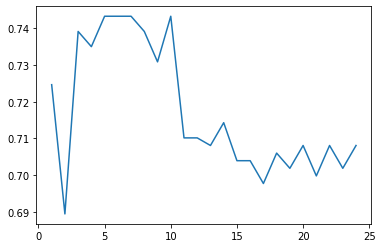

In [58]:
candidate_n_neighbors = np.arange(1,25)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {n: get_accuracy_knn(n, train_X_scaled, val_X_scaled, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [59]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(train_X_scaled, train_y)

KNeighborsClassifier()

In [60]:
knn_model_2.score(val_X_scaled, val_y)

0.7432712215320911

In [61]:
y_pred = knn_model_2.predict(val_X_scaled)

<AxesSubplot:>

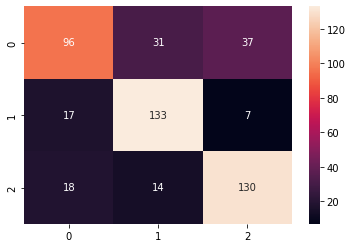

In [62]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NAIVE BAYES

0.4927536231884058


<AxesSubplot:>

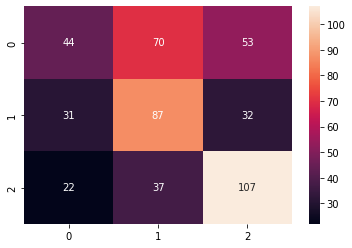

In [81]:
nb_model_1 = GaussianNB()

#Entreno el modelo
nb_model_1.fit(train_X, train_y)

#Realizo una predicción
y_pred = nb_model_1.predict(val_X)
print(nb_model_1.score(val_X, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.505175983436853


<AxesSubplot:>

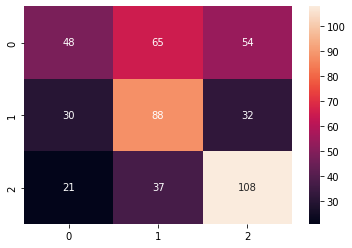

In [82]:
nb_model_2 = GaussianNB()
nb_model_2.fit(train_X_scaled, train_y)
print(nb_model_2.score(val_X_scaled, val_y))
y_pred = nb_model_2.predict(val_X_scaled)

confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# SVM

In [83]:
svm_model_1 = SVC(random_state=22)
svm_model_1.fit(train_X_scaled, train_y)

SVC(random_state=22)

In [84]:
y_pred = svm_model_1.predict(val_X_scaled)

In [85]:
svm_model_1.score(val_X_scaled, val_y)

0.7080745341614907

<AxesSubplot:>

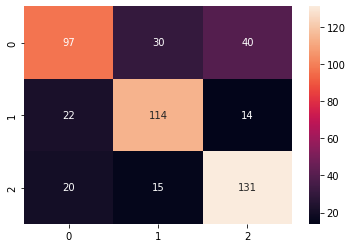

In [86]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [87]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf'] # Some linear fittings last to 7/8 mins. Not recommended at all
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [88]:
svm_grid.fit(train_X_scaled, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   1.2s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   1.2s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   1.2s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.5, gamma=0.001, kernel=rbf; total time=   1.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.8s[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.8s

[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=100, gamma=scale

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=4,
                   param_distributions={'C': [0.5, 1, 10, 100],
                                        'gamma': ['scale', 1, 0.1, 0.01, 0.001,
                                                  0.0001],
                                        'kernel': ['rbf']},
                   verbose=2)

In [89]:
svm_grid.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [90]:
svm_model_2 = SVC(C= 100, gamma= 1, kernel='rbf', random_state=22)
svm_model_2.fit(train_X_scaled, train_y)

SVC(C=100, gamma=1, random_state=22)

In [91]:
y_pred = svm_model_2.predict(val_X_scaled)

In [92]:
svm_model_2.score(val_X_scaled, val_y)

0.7556935817805382

<AxesSubplot:>

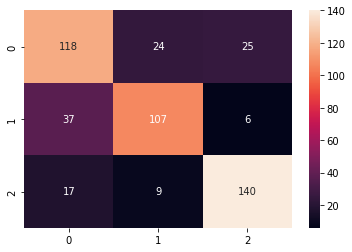

In [93]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# PCA

In [37]:
pca = PCA(n_components=3)
pca.fit(train_X_scaled)

PCA(n_components=3)

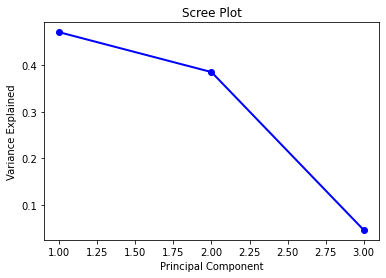

In [38]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [39]:
train_X_scaled_pca = pca.transform(train_X_scaled)
val_X_scaled_pca = pca.transform(val_X_scaled)

In [40]:
train_pc1_coords = train_X_scaled_pca[:,0]
train_pc2_coords = train_X_scaled_pca[:,1]
train_pc3_coords = train_X_scaled_pca[:,2]

# LOGISTIC REGRESSION

/home/tomas/renewable_power_plants/renewable_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6935817805383023


<AxesSubplot:>

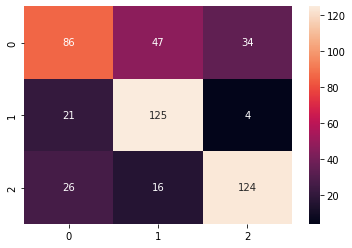

In [108]:
logistic_model_1 = LogisticRegression(random_state=22)
logistic_model_1.fit(train_X, train_y)
y_pred = logistic_model_1.predict(val_X)
print(logistic_model_1.score(val_X, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# LDA

In [97]:
lda = LDA(n_components = 2)
train_X_scaled_lda = lda.fit_transform(train_X_scaled, train_y)
val_X_scaled_lda = lda.transform(val_X_scaled)

0.3416149068322981


<AxesSubplot:>

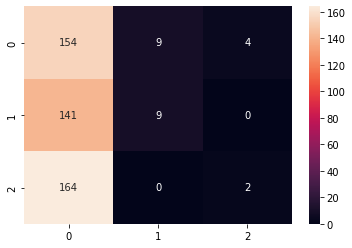

In [98]:
lda.fit(train_X_scaled_lda, train_y)
y_pred = lda.predict(val_X_scaled_lda)
print(lda.score(val_X_scaled_lda, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NEURAL NETWORK

0.6770186335403726


<AxesSubplot:>

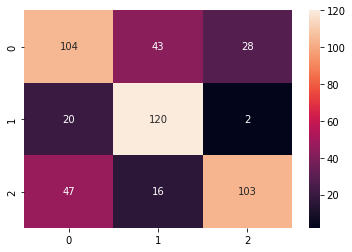

In [41]:
nn_model_1 = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
nn_model_1.fit(train_X, train_y)
y_pred = nn_model_1.predict(val_X)
print(nn_model_1.score(val_X, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# TEST PREDICTION

In [99]:
df_to_predict = pd.read_csv(dir_data_external/"data_predict.csv", index_col=['index'])
df_to_predict.drop(columns=['latitude','longitude'], inplace=True)

In [100]:
y_predicted_test = xgbclass_model_2.predict(df_to_predict)
print(y_predicted_test)

ValueError: Feature shape mismatch, expected: 240, got 280

In [357]:
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
24713,Solar,1
24717,Other,0
24749,Wind,2


# VOTING CLASSIFIER

# ADABOOST

# GRADIENT TREE BOOSTING